# 3장
- 분류

# 데이터 불러오기
- MNIST : 손으로 쓴 70,000개 숫자 이미지

In [1]:
import sys
import sklearn
import numpy as np
import os
import pandas as pd

import tarfile #압축되지 않은 파일
import urllib.request

import matplotlib as mpt
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

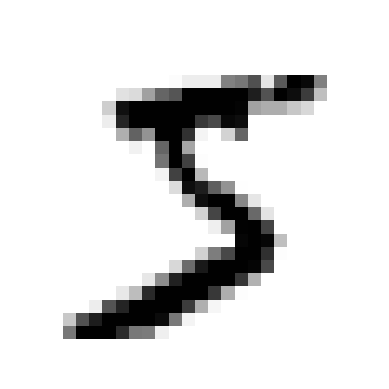

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

In [5]:
y = y.astype(np.uint8)
y[0]

5

## 3.2 이진 분류기 훈련

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [ ]:
# 확률적 경사 하강법(Stochastic Gradient Descent)
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

## 3.3 성능 측정

### 3.3.1 교차검증을 사용한 정확도 측정

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# shuffle=False가 기본값이기 때문에 random_state를 삭제하던지 shuffle=True로 지정하라는 경고가 발생합니다.
# 0.24버전부터는 에러가 발생할 예정이므로 향후 버전을 위해 shuffle=True을 지정합니다.
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [11]:
# k = 3인 k-fold cross validation
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [12]:
# 모든 이미지를 5가 아님으로 분류하는 분류기 생성
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [13]:
# 이미지의 10%만 숫자 5이므로 무조건 5가 아니라고 하면 정확도 90%이상이 나옴
# 따라서 정확도 말고 다른 성능 측정 지표가 필요함
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### 3.2 오차 행렬(Confusion Matrix)

In [14]:
# cross-validation을 수행하지만 평가 점수를 반환하지 않고 각 test fold에서 얻은 예측을 반환
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [16]:
#만약 완벽한 분류기라면?
y_train_perfect_predictions = y_train_5  
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [17]:
# 정밀도(Precision): 5라고 예측한 값들 중 실제 5인 확률
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [18]:
# 재현율(recall): 실제 5인 값들 중에 맞게 예측한 확률
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [19]:
# F1-score: precision과 recall의 조화평균
# 정밀도와 재현율 모두 높게 나타날 수 없음 -> 정밀도/재현율 트레이드오프
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 3.3.4 정밀도/재현율 트레이드오프

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [21]:
threshold=0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [22]:
# 임계값: 8000일때
threshold=8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [23]:
# 적절한 임계값 찾아보기

#1. train set에 있는 모든 sample의 점수를 구하기
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = 'decision_function')

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

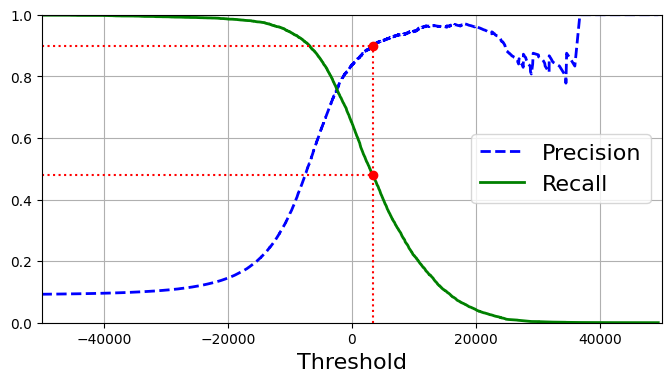

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # 범례위치
    plt.xlabel("Threshold", fontsize=16)        # X축
    plt.grid(True)                              # grid형식
    plt.axis([-50000, 50000, 0, 1])             # x축, y축 범위



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown                                            # Not shown
plt.show()

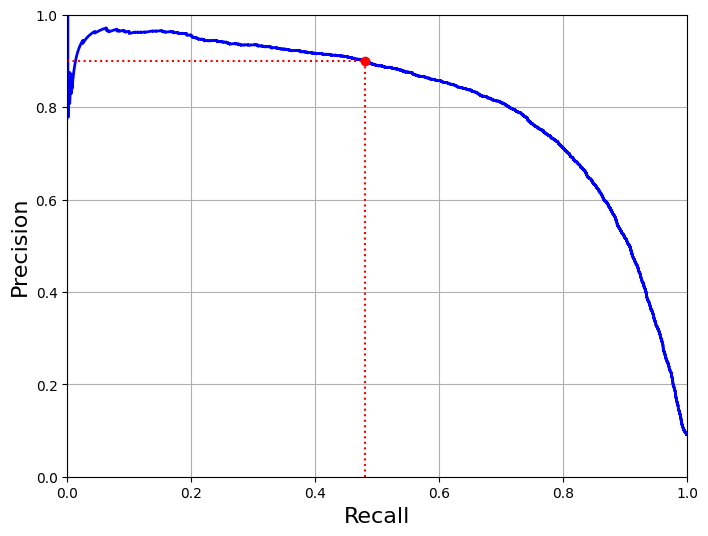

In [26]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

- recall = 0.8부터 precision이 급격히 줄어든다
- 이 하강점 직전을 트레이드오프로 선택하는 것이 good


In [27]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [29]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### 3.3.5 ROC 곡선
- 거짓 양성비율에 대한 진짜 양성비율
- recall 값에 대한 1-특이도 그래프

- 곡선 아래의 면적(AUC) = 1: 완벽, 0.5: 완전 랜덤

In [30]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

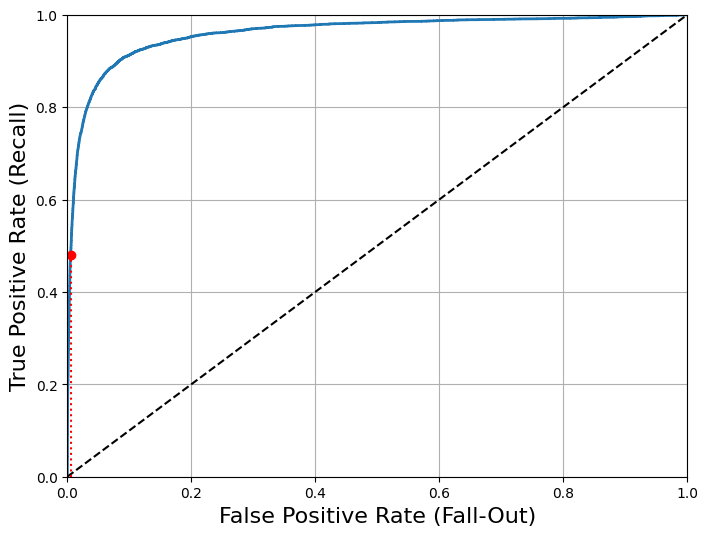

In [31]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
plt.show()

In [32]:
# AUC 계산
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [33]:
# randomforest와 비교해보기
# RandomForestClassifier에는 decision_function() 메서드 없음
# 대신 predict_proba() 메서드 사용
# -> 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method = 'predict_proba')

In [34]:
# 점수 = 양성 클래스의 확률
y_scores_forest = y_probas_forest[:, 1] 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

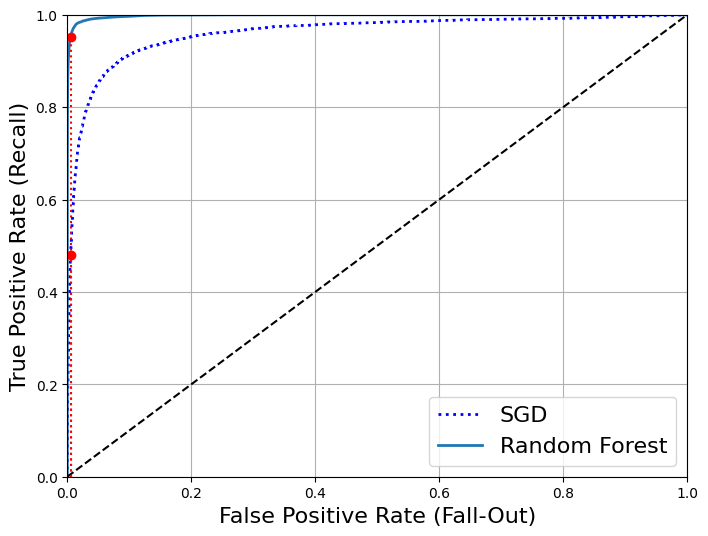

In [36]:
# 2개 ROC 곡선 비교
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()


- RandomForestClassifier이 더 좋아보인다.

In [37]:
# AUC 계산
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [40]:
#정밀도
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [41]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## 3.4 다중분류
- 둘 이상의 클래스를 구별

In [42]:
# 서포트벡터머신

from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [43]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [44]:
# 클래스 5에 해당되는 점수가 최고점
np.argmax(some_digit_scores)

5

In [45]:
svm_clf.classes_[5]

5

## 연습문제

### Q1. test set에서 97% 정확도 갖게 하기
- KNeighborsClassifier 이용
- 코드 시간이 오래걸려서 붙여넣기함

1. GridSearchCV를 통해 하이퍼파라미터값 찾기(weights, n_neighbors)
2. fit하고 predict한 뒤에 accuracy score 확인

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

In [ ]:
# 최적의 하이퍼파라미터
grid_search.best_params_

In [ ]:
# 최적의 파라미터일때 점수
grid_search.best_score_

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

### Q2. 타이타닉데이터로 승객의 생존 여부 예측해보기

- PassengerId: 각 승객의 고유 식별자.
- Survived: 타깃입니다. 0은 생존하지 못한 것이고 1은 생존을 의미합니다.
- Pclass: 승객 등급. 1, 2, 3등석.
- Name, Sex, Age: 이름 그대로 의미입니다.
- SibSp: 함께 탑승한 형제, 배우자의 수.
- Parch: 함께 탑승한 자녀, 부모의 수.
- Ticket: 티켓 아이디
- Fare: 티켓 요금 (파운드)
- Cabin: 객실 번호
- Embarked: 승객이 탑승한 곳. C(Cherbourg), Q(Queenstown), S(Southampton)

In [3]:
# 데이터 불러오기
import os
import urllib.request

TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_titanic_data()   

In [4]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [6]:
train= load_titanic_data("train.csv")
test= load_titanic_data("test.csv")

In [8]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [9]:
test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [10]:
# PassengerID는 인덱스열로 지정
train = train.set_index('PassengerId')
test = test.set_index('PassengerId')

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


- Age, Cabin, Embarked : null값 존재
- Cabin은 77%가 null값이므로 무시
- Age 결측치 처리: 중간나이로 대체
- Name, Ticket은 무시

In [13]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [14]:
# 범주형 자료들 확인
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [15]:
# 범주형 자료들 확인
train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [17]:
# 범주형 자료들 확인
train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [18]:
# 범주형 자료들 확인
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [19]:
# 전처리 파이프라인 만들기
# 먼저 수치형 특성에 대한 파이프라인 만들기
from sklearn.pipeline import Pipeline

# SimpleImputer를 사용하여 결측값을 중앙값(median)으로 대체
from sklearn.impute import SimpleImputer

#StandardScaler를 사용하여 특성들을 평균이 0이고 표준편차가 1이 되도록 표준화
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

In [20]:
# 범주형 전처리 파이프라인

# SimpleImputer를 사용하여 결측값을 가장 빈번한 값(most frequent value)으로 대체
# OneHotEncoder를 사용하여 범주형 특성을 원-핫 인코딩(one-hot encoding
# sparse=False로 설정하여 밀집(dense) 배열을 반환
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [21]:
# 숫자와 범주형 파이프라인을 연결
# 변수에 따라 적용되게끔 정리

from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [22]:
# train 데이터에 전처리 파이프라인 적용
X_train = preprocess_pipeline.fit_transform(
    train[num_attribs + cat_attribs])
X_train

array([[-0.56573646,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66386103,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276197, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [23]:
# 레이블
y_train = train["Survived"]

In [24]:
# RandomForestClassifier로 모델 훈련하기
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [25]:
# RandomForestClassifier로 만든 모델을 이용하여 test셋 예측
# 먼저 test셋도 전처리 파이프라인 적용(fit_transform이 아닌 transform!)
X_test = preprocess_pipeline.transform(test[num_attribs + cat_attribs])
y_pred = forest_clf.predict(X_test)

In [26]:
# 예측결과를 교차검증으로 평가해보기
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8092759051186016

In [27]:
# SVC로 모델을 만들어보기
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

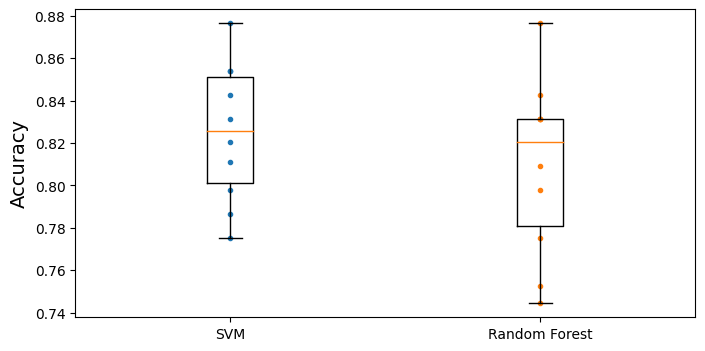

In [28]:
# boxplot을 통해 randomforest와 svc 비교
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()


- randomforest는 10개 cross-validation 중 하나가 유독 높게 나옴
    - 전반적인 평균 점수는 svm에 비해 낮은걸 알 수 있음
- 따라서 SVM 분류기가 일반화를 더 잘한다는 걸 확인해볼 수 있다.

In [29]:
# 여기서 그치지말고 feature-engineering 시도해보기